In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
DIRECTORY = r"C:\Python37\Projects\Face-Mask-Detection-master\dataset\Train"
CATEGORIES = ["Mask", "Non Mask"]

In [6]:
data = []
labels = []

In [7]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [11]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
for layer in baseModel.layers:
	layer.trainable = False

In [16]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

C:\Users\12200\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
15/15 [==============================] - 19s 1s/step - loss: 0.7589 - accuracy: 0.6021 - val_loss: 0.5029 - val_accuracy: 0.8833
Epoch 2/20
15/15 [==============================] - 14s 961ms/step - loss: 0.5179 - accuracy: 0.8083 - val_loss: 0.3560 - val_accuracy: 0.9500
Epoch 3/20
15/15 [==============================] - 14s 951ms/step - loss: 0.3993 - accuracy: 0.8771 - val_loss: 0.2658 - val_accuracy: 0.9583
Epoch 4/20
15/15 [==============================] - 15s 973ms/step - loss: 0.2952 - accuracy: 0.9271 - val_loss: 0.2043 - val_accuracy: 0.9667
Epoch 5/20
15/15 [==============================] - 21s 1s/step - loss: 0.2220 - accuracy: 0.9500 - val_loss: 0.1645 - val_accuracy: 0.9667
Epoch 6/20
15/15 [==============================] - 69s 5s/step - loss: 0.1951 - accuracy: 0.9479 - val_loss: 0.1361 - val_accuracy: 0.9667
Epoch 7/20
15/15 [==============================] - 15s 974ms/step - loss: 0.1703 - accuracy: 0.9667 - val_loss: 0.1183 - val_a

In [18]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [19]:
predIdxs = np.argmax(predIdxs, axis=1)


In [20]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

        Mask       0.97      1.00      0.98        60
    Non Mask       1.00      0.97      0.98        60

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [21]:
model.save("mask_detector.model", save_format="h5")

C:\Users\12200\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


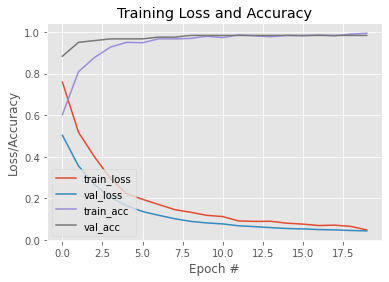

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")